In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

train_file = np.load('./data/train.npz')
data = train_file['data']
print("train_data's shape", data.shape)

test_file = np.load('./data/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


The training set should be of shape (10000, 50, 110, 6). There are 10,000 training scenes, each scene contains 50 agents' trajectories over 110 time steps, and each time step has 6 dimensions.

Columns
The 6 dimensions are, respectively:

position_x: x-coordinate of the agent's position <br>
position_y: y-coordinate of the agent's position <br>
velocity_x: x-component of the agent's velocity <br>
velocity_y: y-component of the agent's velocity <br>
heading: heading angle of the agent in radians <br>
object_type: encoded object type. The integers indexes this array: <br>
['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown'] <br>

For many of the agents, their trajectory is not complete. In the case that this happens or when there are less than 50 agents in the scene, we pad the matrix with zeros. (so don't be surprised when you see a lot of zeros!) <br>

Your task is to predict the ego vehicle (agent index 0)'s trajectory. We will pre in a scene given the first 50 time steps (5 seconds) to predict the next 60 time steps. <br>
This means that the test set input has shape (2100, 50, 50, 6) (2100 scenes, 50 agents, 50 time steps input, 6 dimensions), and you are expected to upload a csv file of shape (2100 * 60, 2) (2100 scenes, 1 ego agent, 60 time steps prediction, 2 dimensions - just x and y). 

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

train_data, val_data = train_test_split(data, test_size=0.15, random_state=42)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


In [4]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32, device=device),
            origin=torch.tensor(origin, dtype=torch.float32, device=device).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32, device=device),
        )
        return data_item

In [5]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(val_data, scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

In [42]:
class Simple_GRU(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(Simple_GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.drop = nn.Dropout(p=0.3)
        

    def forward(self, x):
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.gru(x)
        
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc1(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [44]:
class TrajPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=2, batch_first=True, 
                                                   dim_feedforward=128, dropout=0.2,
                                                  activation='relu')
        layer_norm = nn.LayerNorm(6)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1, 
                                                         norm=layer_norm)
        self.gru = Simple_GRU(input_dim=12)
        
    def forward(self, x):
        x = x.reshape(-1, 50, 50, 6)

        x_copy = x.clone().detach()
        
        x = x.permute(0, 2, 1, 3)
        x = x.reshape(-1, 50, 6)

        encoded_out = self.transformer_encoder(x)

        encoded_out = encoded_out.reshape(-1, 50, 50, 6)
        encoded_out = encoded_out.permute(0, 2, 1, 3)

        out = torch.cat((x_copy, encoded_out), dim=-1)
        
        return self.gru(out)

In [65]:
def get_val_loss(model, loss_fn, val_dataloader):
    
    model.eval()
    
    with torch.no_grad():
        total_val_loss = 0
        total_val_mse = 0

        for batch in val_dataloader:
            batch = batch.to(device)
            x, y = batch.x, batch.y.reshape(-1, 60, 2)
                  
            pred   = model(x)
            loss   = loss_fn(pred, y)

            total_val_loss += loss_fn(pred, y).item()
    
            # show MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            total_val_mse += nn.MSELoss()(pred, y).item()
    
    val_loss = total_val_loss / len(val_dataloader)
    val_mse = total_val_mse / len(val_dataloader)
            
    print(f'Validation Loss: {val_loss:.4f} Validation MSE: {val_mse:.4f}')
    return val_loss, val_mse
    
def train(model, train_dataloader, val_dataloader, epochs=20, lr=0.001, device='cpu'):

    best_val_loss = float('inf')
    no_improvement = 0
    early_stopping_patience = 10

    train_loss = []
    val_loss = []
    val_mse = []
    
    model.to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.25)
    loss_fn = nn.MSELoss()

    for epoch in range(1, epochs+1):
        model.train()
        total = 0.0
        
        for batch in tqdm.tqdm(train_dataloader):
            batch = batch.to(device)
            
            x, y = batch.x, batch.y.reshape(-1, 60, 2)
                  
            pred   = model(x)
            loss   = loss_fn(pred, y)
            opt.zero_grad()
            loss.backward()
            #clip_grad_norm_(model.parameters(), 4.0)
            opt.step()
            total += loss.item()
        
        avg = total/len(train_dataloader)
        #sched.step(avg)
        scheduler.step()

        train_loss.append(avg)
        
        print(f"Epoch {epoch:02d} — MSE: {avg:.4f}")
        v_loss, v_mse = get_val_loss(model, loss_fn, val_dataloader)

        val_loss.append(v_loss)
        val_mse.append(v_mse)

        if v_loss < best_val_loss - 1e-3:
            best_val_loss = v_loss
            no_improvement = 0
            torch.save(model.state_dict(), "best_pred1.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break
        
    return model, train_loss, val_loss, val_mse

In [67]:
# initialize & train
model = TrajPredictor()
model, train_loss, val_loss, val_mse = train(model, train_dataloader, val_dataloader, epochs=30, lr=0.001, device=device)

100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.47it/s]


Epoch 01 — MSE: 1.0173
Validation Loss: 0.4175 Validation MSE: 20.4572


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.27it/s]


Epoch 02 — MSE: 0.3910
Validation Loss: 0.3428 Validation MSE: 16.7949


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.27it/s]


Epoch 03 — MSE: 0.3145
Validation Loss: 0.2792 Validation MSE: 13.6826


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.19it/s]


Epoch 04 — MSE: 0.2776
Validation Loss: 0.2628 Validation MSE: 12.8749


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.31it/s]


Epoch 05 — MSE: 0.2593
Validation Loss: 0.2440 Validation MSE: 11.9566


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.35it/s]


Epoch 06 — MSE: 0.2467
Validation Loss: 0.2393 Validation MSE: 11.7265


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.33it/s]


Epoch 07 — MSE: 0.2370
Validation Loss: 0.2310 Validation MSE: 11.3173


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.19it/s]


Epoch 08 — MSE: 0.2358
Validation Loss: 0.2354 Validation MSE: 11.5358


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.39it/s]


Epoch 09 — MSE: 0.2270
Validation Loss: 0.2482 Validation MSE: 12.1601


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.66it/s]


Epoch 10 — MSE: 0.2250
Validation Loss: 0.2280 Validation MSE: 11.1720


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.67it/s]


Epoch 11 — MSE: 0.2239
Validation Loss: 0.2418 Validation MSE: 11.8489


100%|█████████████████████████████████████████| 532/532 [00:31<00:00, 17.16it/s]


Epoch 12 — MSE: 0.2226
Validation Loss: 0.2225 Validation MSE: 10.9046


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.26it/s]


Epoch 13 — MSE: 0.2191
Validation Loss: 0.2213 Validation MSE: 10.8443


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.21it/s]


Epoch 14 — MSE: 0.2166
Validation Loss: 0.2192 Validation MSE: 10.7389


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.26it/s]


Epoch 15 — MSE: 0.2122
Validation Loss: 0.2178 Validation MSE: 10.6717


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.31it/s]


Epoch 16 — MSE: 0.2138
Validation Loss: 0.2156 Validation MSE: 10.5633


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.35it/s]


Epoch 17 — MSE: 0.2117
Validation Loss: 0.2153 Validation MSE: 10.5507


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.69it/s]


Epoch 18 — MSE: 0.2125
Validation Loss: 0.2148 Validation MSE: 10.5232


100%|█████████████████████████████████████████| 532/532 [00:29<00:00, 17.74it/s]


Epoch 19 — MSE: 0.2101
Validation Loss: 0.2122 Validation MSE: 10.3995


100%|█████████████████████████████████████████| 532/532 [00:31<00:00, 17.14it/s]


Epoch 20 — MSE: 0.2071
Validation Loss: 0.2196 Validation MSE: 10.7627


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.42it/s]


Epoch 21 — MSE: 0.1939
Validation Loss: 0.2017 Validation MSE: 9.8813


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.27it/s]


Epoch 22 — MSE: 0.1935
Validation Loss: 0.2003 Validation MSE: 9.8171


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.29it/s]


Epoch 23 — MSE: 0.1912
Validation Loss: 0.2014 Validation MSE: 9.8695


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.28it/s]


Epoch 24 — MSE: 0.1927
Validation Loss: 0.2003 Validation MSE: 9.8161


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.24it/s]


Epoch 25 — MSE: 0.1909
Validation Loss: 0.1991 Validation MSE: 9.7577


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.30it/s]


Epoch 26 — MSE: 0.1910
Validation Loss: 0.2029 Validation MSE: 9.9428


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.28it/s]


Epoch 27 — MSE: 0.1914
Validation Loss: 0.1972 Validation MSE: 9.6624


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.28it/s]


Epoch 28 — MSE: 0.1909
Validation Loss: 0.2054 Validation MSE: 10.0627


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.27it/s]


Epoch 29 — MSE: 0.1920
Validation Loss: 0.2013 Validation MSE: 9.8615


100%|█████████████████████████████████████████| 532/532 [00:30<00:00, 17.26it/s]


Epoch 30 — MSE: 0.1903
Validation Loss: 0.2015 Validation MSE: 9.8724


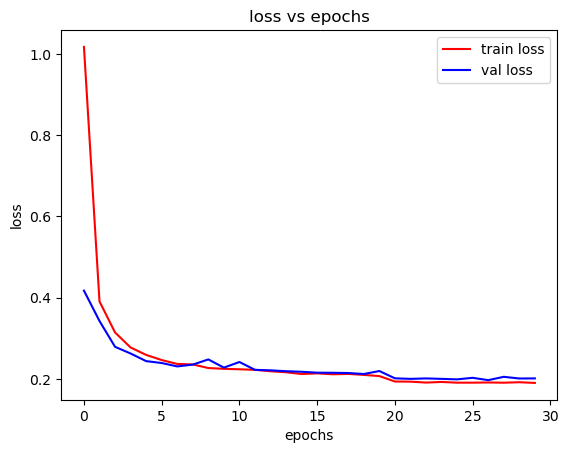

In [81]:
import matplotlib.pyplot as plt

plt.plot(train_loss, 'r', label='train loss')
plt.plot(val_loss, 'b', label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.savefig('loss_vs_epochs.png')

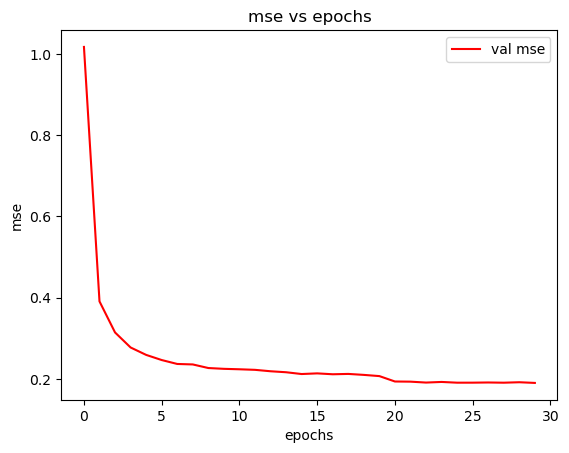

In [ ]:
plt.plot(val_mse, 'r', label='val mse')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('mse vs epochs')
plt.legend()
plt.savefig('val_mse_vs_epochs.png')

In [70]:
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [71]:
model.load_state_dict(torch.load("best_pred1.pt"))
model.eval()

loss_fn = nn.MSELoss()
get_val_loss(model, loss_fn, val_dataloader)

Validation Loss: 0.1972 Validation MSE: 9.6624


(0.19719147246251714, 9.662382884228483)

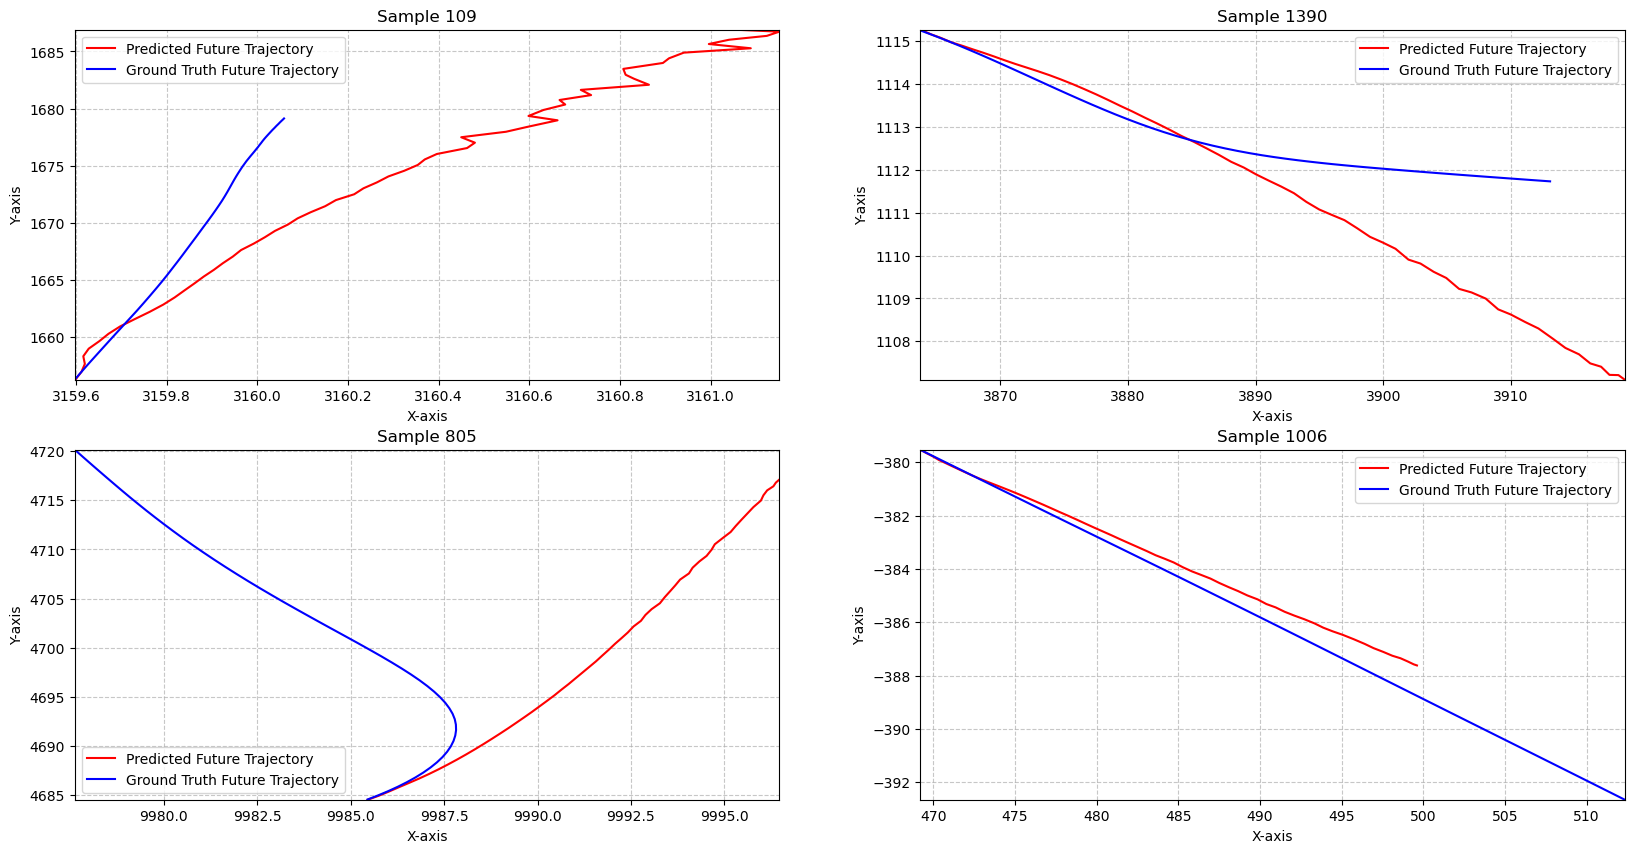

In [72]:
# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch.x)
    
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)
    
    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.savefig('trajectories.png')
plt.show()

In [79]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        x = batch.x
        pred_norm = model(x)
        
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
        
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission1.csv', index=True)